# Exercise with A/B Testing

### Prompt

Let’s imagine you work on the For You Page at TikTok. Your team decides that instead of a heart button, they want to change it to star hoping that it will lead to a higher engagement/like rate. The product manager told you that the current conversion rate is about 6% on average throughout the year, and that the team would be happy with an increase of 3%, meaning that the new design will be considered a success if it raises the engagement rate to 9%.

Before rolling out the change, the team would be more comfortable testing it on a small number of users to see how it performs, so you suggest running an A/B test on a subset of the user base users.

In [45]:
# Packages imports
import numpy as np
import pandas as pd

# probability distributions & statistical functions
import scipy.stats as stats
# estimating statistical models
import statsmodels.stats.api as sms

import matplotlib.pyplot as plt
import seaborn as sns

#rounding function
from math import ceil



### Sample Size Calculation

In [46]:
# Calculate effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.13, 0.15)

In [47]:
# Calculate sample size needed
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )    

required_n = ceil(required_n)                                                  
print(required_n)

4720


### Collecting and preparing the data

In [48]:
# Load the tiktok_data.csv into a dataframe

df = pd.read_csv('tiktok_data.csv')
df.head()

,user_id,timestamp,group,button,liked
0,767017,2017-01-12 22:58:15,control,star,0
1,793849,2017-01-23 22:36:11,treatment,star,0
2,905617,2017-01-20 14:12:19,treatment,star,0
3,746742,2017-01-23 11:38:30,control,heart,0
4,892356,2017-01-05 9:35:15,treatment,star,1


In [49]:
# Get the info of the dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275781 entries, 0 to 275780
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    275781 non-null  int64 
 1   timestamp  275781 non-null  object
 2   group      275781 non-null  object
 3   button     275781 non-null  object
 4   liked      275781 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 10.5+ MB


In [50]:
pd.crosstab(df['group'], df['button'])

button,heart,star
group,,
control,136002,1816
treatment,1855,136108


In [51]:
# Make sure all the control group are seeing the star button and viceversa

df_control = df.loc[(df['group'] == 'control')]
df_control = df_control[df.button != 'star']

df_treat = df.loc[(df['group'] == 'treatment')]
df_treat = df_treat[df.button != 'heart']

df_clean = pd.concat([df_control, df_treat], ignore_index=True)
df = df_clean

<ipython-input-51-67f5bb06b0f4>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_control = df_control[df.button != 'star']
<ipython-input-51-67f5bb06b0f4>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_treat = df_treat[df.button != 'heart']


In [52]:
pd.crosstab(df['group'], df['button'])

button,heart,star
group,,
control,136002,0
treatment,0,136108


In [53]:
# Check that no users have been sampled multiple times 

session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(multi_users)

1


In [54]:
# If there are users who have been sampled multiple times, remove them from the dataframe

users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(df.shape[0])

272108


#### Now that our DataFrame is nice and clean, we can proceed and sample n=4720 entries for each of the groups. We can use pandas' DataFrame.sample() method to do this, which will perform Simple Random Sampling for us.

In [63]:
# Perform simple random sampling to split the data into control and treatment

control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

In [64]:
# Create one table called ab_test that has both the cleaned control and treatment data

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,button,liked
0,774220,2017-01-23 23:54:49,control,heart,0
1,909347,2017-01-16 22:29:50,control,heart,0
2,802016,2017-01-13 1:23:54,control,heart,0
3,731018,2017-01-03 23:11:35,control,heart,0
4,659962,2017-01-20 22:31:59,control,heart,0
...,...,...,...,...,...
9435,768403,2017-01-06 5:11:49,treatment,star,0
9436,642225,2017-01-18 4:27:07,treatment,star,0
9437,821140,2017-01-10 18:44:51,treatment,star,1
9438,838923,2017-01-16 18:33:20,treatment,star,0


In [65]:
# Count the test groups to make sure that they're balanced 

ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

### Analysis Visualization

In [67]:
# Find the like rate by group


# Find the Std. deviation of the proportion


# Find the Std. error of the proportion (std / sqrt(n))


# Calculate the final like rate

conversion_rates = ab_test.groupby('group')['liked']

std_p = lambda x: np.std(x)              # compute the std. deviation of the proportion
se_p = lambda x: stats.sem(x)            # compute the std error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.114,0.318,0.005
treatment,0.119,0.324,0.005


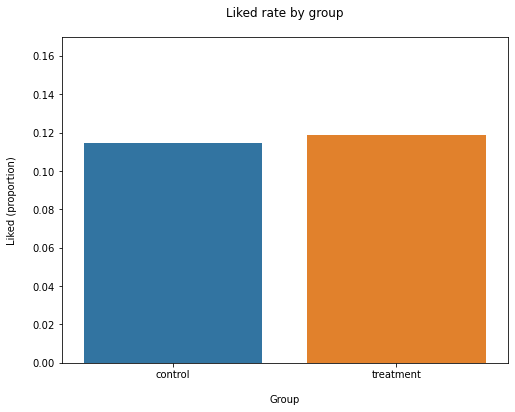

In [69]:
# Plot the like rate by group on a bar plot

plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['liked'], ci=False)

plt.ylim(0, 0.17)
plt.title('Liked rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Liked (proportion)', labelpad=15);

### Testing for Stat Sig

In [71]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Get the like count for both control and treatment groups


# Get the number of samples in both groups


# Sum up the number of successes (likes) in both groups

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test['group'] == 'control']['liked']
treatment_results = ab_test[ab_test['group'] == 'treatment']['liked']

n_con = control_results.count()
n_treat = treatment_results.count()

successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

print(n_con)
print(n_treat)
print(successes)
print(nobs)

4720
4720
[540, 561]
[4720, 4720]


In [72]:
# Find the z statistic and p value for proportions based on normal ztest

z_stat, pval = proportions_ztest(successes, nobs=nobs) #Test for proportions based on normal ztest
# Find the confidence intervals for each test group
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05) 


In [73]:
# print z statistic

# print p-value

# print ci 95% for control group

# print ci 95% for treatment group

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.67
p-value: 0.501
ci 95% for control group: [0.105, 0.123]
ci 95% for treatment group: [0.110, 0.128]


### Were the results signficant? 

In [74]:
print("The change is not very significant")

The change is not very significant


### What would you advise the engineering team to do moving forward?

In [ ]:
print("I would advice the engineering team to try to test another group, and to keep the heart")